#**COVID 19 ENGLISH TWEET CLASSIFICATION**
Dataset link:

- !gdown --id [1aqWjA4bbRdI_LtM_AWtgZMdmTbf-JO_i](https://) #train_clean.tsv file
- !gdown --id [1TL3U9H6h7PhFh1p8Z5jhHzaacAppBLfK](https://)  #test_clean.tsv file

#Embedding - **Word2Vec**
#Model - **Support Vector Machine**

**1. Let’s load the libraries**

In [1]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**2. Let’s read train and test datasets**

In [2]:
!gdown --id 1aqWjA4bbRdI_LtM_AWtgZMdmTbf-JO_i  #train_clean.tsv file
!gdown --id 1QtxPpQD5MwsamifpuGiyNjeX9lfE9UG_  #test_clean.tsv file

train = pd.read_csv("/content/train_clean.tsv",sep="\t",header=0)
test = pd.read_csv("/content/test_clean.tsv",sep="\t",header=0)

Label_dict = {
    'INFORMATIVE': 1,
    'UNINFORMATIVE': 0
}
train['Label'] = train.Label.replace(Label_dict)


Downloading...
From: https://drive.google.com/uc?id=1aqWjA4bbRdI_LtM_AWtgZMdmTbf-JO_i
To: /content/train_clean.tsv
100% 1.70M/1.70M [00:00<00:00, 99.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QtxPpQD5MwsamifpuGiyNjeX9lfE9UG_
To: /content/test_clean.tsv
2.51MB [00:00, 80.3MB/s]


**3. Data Inspection**

3.1 Let’s check out a few *Uninformative Tweets*.

In [3]:
train[train['Label'] == 0].head()

,Id,Text,Label
4,1.239674e+18,OKLAHOMA CITY The State Department of Education announced Monday the closure of all K12 public schools statewide until at least April 6 as the number of COVID19 cases climb and the risk of commu...,0
5,1.240790e+18,Democrats somehow managed to fight ebola without calling it the African virus A cluster of COVID19 cases has emerged in New York CItys Hassidic neighborhood so its only a matter of time before the...,0
8,1.236363e+18,Coronavirus impact Close Taj Mahal till March end Agra Mayor urges people scared of foreigners and looked at them with suspicion situation could turn nasty and tarnish Indias image internationa...,0
9,1.245725e+18,Dear In COVID2019 casegive tools amp machines to Bangladesh not money Bcoz Climate Fund money was stolen by the Ruling Party HTTPURL,0
10,1.240721e+18,Los Angeles is now the county with the highest number of coronavirus cases in California breaks down the impact of COVID19 on LA from cancelled college commencements to haphazard health screening...,0


3.2 Now check out a few *Informative Tweets*.

In [4]:
train[train['Label'] == 1].head()

,Id,Text,Label
0,1.241490e+18,Official death toll from covid19 in the United Kingdom is now GREATER than Germany Poland Switzerland Austria Portugal Greece Sweden Finland Norway Ireland COMBINED UK 675 Million 233 dea...,1
1,1.245916e+18,Dearest Mr President 1169 coronavirus deaths in the US in 24 hours Covid19 pandemic is an international crime from China not a nature disasster Please use your authorities to protect your peopl...,1
2,1.241132e+18,Latest Updates March 20 5274 new cases and 38 new deaths in the United States Illinois Governo Pritzker issues stay at home order for all residents New York Governor Cuomo orders 100 of all noness...,1
3,1.236107e+18,BREAKING 21 people on Grand Princess cruise ship docked off the California coast tested positive for coronavirus including 19 crew members and two passengers Vice Pres Mike Pence says 24 people ...,1
6,1.249147e+18,as number of COVID19 deaths surpassed 100000 worldwide NY surpassed Italy on number of recorded deaths New York state has more coronavirus cases than any country worldwide HTTPURL,1


3.3 Let’s check *dimensions of the train and test dataset*

In [5]:
train.shape, test.shape

((7000, 3), (12000, 2))

#### **Train set has 7000 tweets and test set has 12000 tweets.**

3.4 Let’s have a glimpse at *Label-distribution in the Train and test Dataset*

In [6]:
train["Label"].value_counts()


0    3697
1    3303
Name: Label, dtype: int64

3.5 Now we will check the *distribution of length of the tweets, in terms of words, in both train and test data*

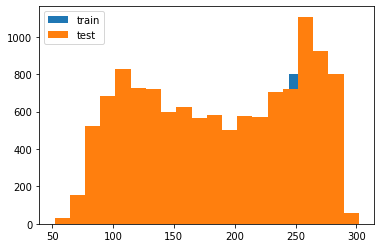

In [7]:
plt.hist(train.Text.str.len(), bins=20, Label='train')
plt.hist(test.Text.str.len(), bins=20, Label='test')
plt.legend()
plt.show()

**4. Data Cleaning**

In any natural language processing task, cleaning raw text data is an important step. It helps in getting rid of the unwanted words and characters which helps in obtaining better features.

4.1 
Before we begin cleaning, let’s first *combine train and test datasets.* Combining the datasets will make it convenient for us to preprocess the data. Later we will split it back into train and test data.

In [8]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(19000, 3)

4.2 Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
def clean_text(txt):
    """""
    cleans the input text in the following steps
    1- replace contractions
    2- removing punctuation
    3- spliting into words
    4- removing stopwords
    5- removing leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)

    # Convert to lowercase
    txt = txt.lower()

    
    #remove punctuations
    txt = re.sub('[0-9]+', '', txt)
    
    # split into words
    from nltk.tokenize import word_tokenize
    words = word_tokenize(txt)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]
    
    cleaned_text = ' '.join(words)
    return cleaned_text
    
combi['Text'] = combi['Text'].apply(lambda txt: clean_text(txt))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
combi.head()

,Id,Label,Text
0,1.241490e+18,1.0,official death toll covid united kingdom greater germany poland switzerland austria portugal greece sweden finland norway ireland combined uk million dead group million dead httpurl
1,1.245916e+18,1.0,dearest mr president coronavirus deaths us hours covid pandemic international crime china nature disasster please use authorities protect people world china chinahastocompensateall
2,1.241132e+18,1.0,latest updates march new cases new deaths united states illinois governo pritzker issues stay home order residents new york governor cuomo orders nonessential workers stay home pennssource coronav...
3,1.236107e+18,1.0,breaking people grand princess cruise ship docked california coast tested positive coronavirus including crew members two passengers vice pres mike pence says people tested negative httpurl httpurl
4,1.239674e+18,0.0,oklahoma city state department education announced monday closure k public schools statewide least april number covid cases climb risk community spread grows httpurl


4.3. *Text Normalization*

Here we will use nltk’s PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [11]:
tokenized_tweet = combi.Text.apply(lambda x: x.split())
tokenized_tweet.head()

0    [official, death, toll, covid, united, kingdom, greater, germany, poland, switzerland, austria, portugal, greece, sweden, finland, norway, ireland, combined, uk, million, dead, group, million, dea...
1    [dearest, mr, president, coronavirus, deaths, us, hours, covid, pandemic, international, crime, china, nature, disasster, please, use, authorities, protect, people, world, china, chinahastocompens...
2    [latest, updates, march, new, cases, new, deaths, united, states, illinois, governo, pritzker, issues, stay, home, order, residents, new, york, governor, cuomo, orders, nonessential, workers, stay...
3    [breaking, people, grand, princess, cruise, ship, docked, california, coast, tested, positive, coronavirus, including, crew, members, two, passengers, vice, pres, mike, pence, says, people, tested...
4              [oklahoma, city, state, department, education, announced, monday, closure, k, public, schools, statewide, least, april, number, covid, cases, climb, risk, community,

4.4 *Now we can normalize the tokenized tweets.*

In [12]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0     [offici, death, toll, covid, unit, kingdom, greater, germani, poland, switzerland, austria, portug, greec, sweden, finland, norway, ireland, combin, uk, million, dead, group, million, dead, httpurl]
1                          [dearest, mr, presid, coronaviru, death, us, hour, covid, pandem, intern, crime, china, natur, disasst, pleas, use, author, protect, peopl, world, china, chinahastocompensateal]
2    [latest, updat, march, new, case, new, death, unit, state, illinoi, governo, pritzker, issu, stay, home, order, resid, new, york, governor, cuomo, order, nonessenti, worker, stay, home, pennssourc...
3         [break, peopl, grand, princess, cruis, ship, dock, california, coast, test, posit, coronaviru, includ, crew, member, two, passeng, vice, pre, mike, penc, say, peopl, test, neg, httpurl, httpurl]
4                                 [oklahoma, citi, state, depart, educ, announc, monday, closur, k, public, school, statewid, least, april, number, covid, case, climb, risk, commun

In [13]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
combi['Text'] = tokenized_tweet
combi.head(5)

,Id,Label,Text
0,1.241490e+18,1.0,offici death toll covid unit kingdom greater germani poland switzerland austria portug greec sweden finland norway ireland combin uk million dead group million dead httpurl
1,1.245916e+18,1.0,dearest mr presid coronaviru death us hour covid pandem intern crime china natur disasst pleas use author protect peopl world china chinahastocompensateal
2,1.241132e+18,1.0,latest updat march new case new death unit state illinoi governo pritzker issu stay home order resid new york governor cuomo order nonessenti worker stay home pennssourc coronaviruscountryu
3,1.236107e+18,1.0,break peopl grand princess cruis ship dock california coast test posit coronaviru includ crew member two passeng vice pre mike penc say peopl test neg httpurl httpurl
4,1.239674e+18,0.0,oklahoma citi state depart educ announc monday closur k public school statewid least april number covid case climb risk commun spread grow httpurl


**5. WORDCLOUD - Visualizing Data**

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

**A) Understanding the common words used in the tweets: WordCloud**
Let’s visualize all the words our data using the wordcloud plot.

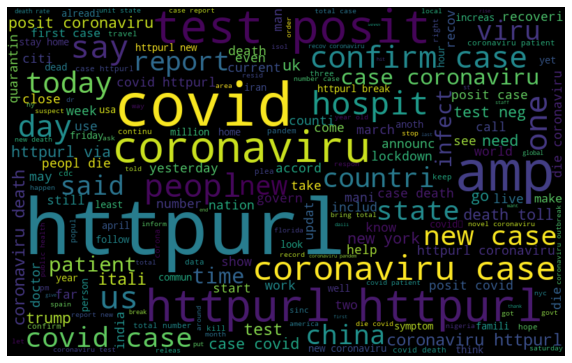

In [14]:
all_words = ' '.join([text for text in combi['Text']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

**B) Words in Uninformative Tweets**

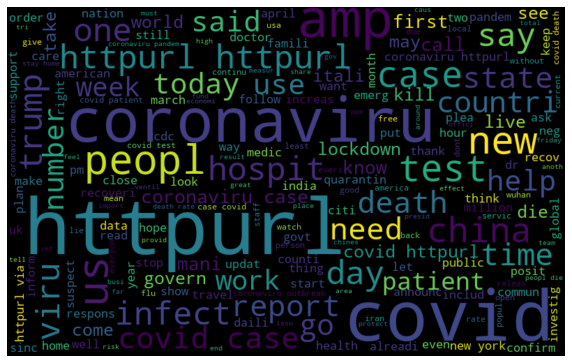

In [15]:
normal_words =' '.join([text for text in combi['Text'][combi['Label'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**C) Words in Informative Tweets**

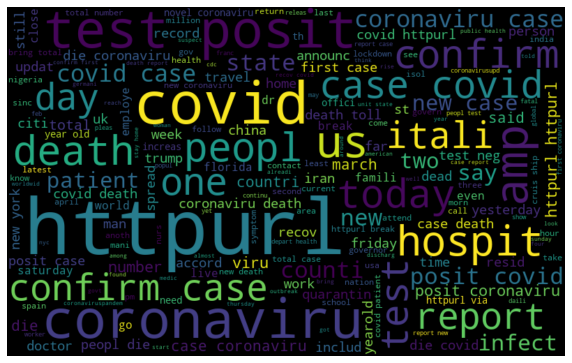

In [16]:
negative_words = ' '.join([text for text in combi['Text'][combi['Label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
import gensim

#**Word embeddings**

Word embeddings are the modern way of representing words as vectors. The objective of word embeddings is to redefine the high dimensional word features into low dimensional feature vectors by preserving the contextual similarity in the corpus.

**6. Word2Vec Embeddings**

Word2Vec is not a single algorithm but a combination of two techniques – **CBOW (Continuous bag of words)** and **Skip-gram** model. Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). Both of these techniques learn weights which act as word vector representations.

CBOW tends to predict the probability of a word given a context. A context may be a single adjacent word or a group of surrounding words. The Skip-gram model works in the reverse manner, it tries to predict the context for a given word.

There are three laters: - an input layer, - a hidden layer, and - an output layer.

In [ ]:
%%time

tokenized_tweet = combi['Text'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['Text']), epochs=20)

6.1 Let’s play a bit with our Word2Vec model and see how does it perform. We will specify a word and the model will pull out the most similar words from the corpus.

In [ ]:
model_w2v.wv.most_similar(positive="dinner")

In [ ]:
model_w2v.most_similar(positive="trump")

6.2 From the above two examples, we can see that our word2vec model does a good job of finding the most similar words for a given word. But how is it able to do so? That’s because it has learned vectors for every unique word in our data and it uses cosine similarity to find out the most similar vectors (words).

Let’s check the vector representation of any word from our corpus.

In [ ]:
model_w2v['food']

In [ ]:
len(model_w2v['food']) #The length of the vector is 200

6.3 Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

6.4 Preparing word2vec feature set…

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
xtrain_w2v = wordvec_df.iloc[:7000,:]
ytrain = train["Label"]
xtest_w2v = wordvec_df.iloc[7000:,:]

In [ ]:
print(xtrain_w2v.shape, xtest_w2v.shape, ytrain.shape)

**7. Model Implementation**

**Support Vector Machine**

In [ ]:
from sklearn import svm

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain) 
SVM_pred = svc.predict(xtest_w2v)
print(classification_report(ytrain, SVM_pred))

In [ ]:
np.savetxt('/content/testpred_w2vSVM.txt',SVM_pred,delimiter=',')